Start of program: Pre-processing

In [1]:
%pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase

# Scipy
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy
# Others
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import pickle
from math import modf

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from collections import Counter

In [3]:
file_dir = "Bank Customer Churn Prediction.csv"
df = pd.read_csv(file_dir)
df.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df = df.drop_duplicates()
print("Shape of dfset: " + str(df.shape))

Shape of dfset: (10000, 12)


In [5]:
outcome_window = df[['customer_id', 'churn']]
print(outcome_window.head(5))

   customer_id  churn
0     15634602      1
1     15647311      0
2     15619304      1
3     15701354      0
4     15737888      0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


customer_id         0.0
credit_score        0.0
country             0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
products_number     0.0
credit_card         0.0
active_member       0.0
estimated_salary    0.0
churn               0.0
dtype: float64

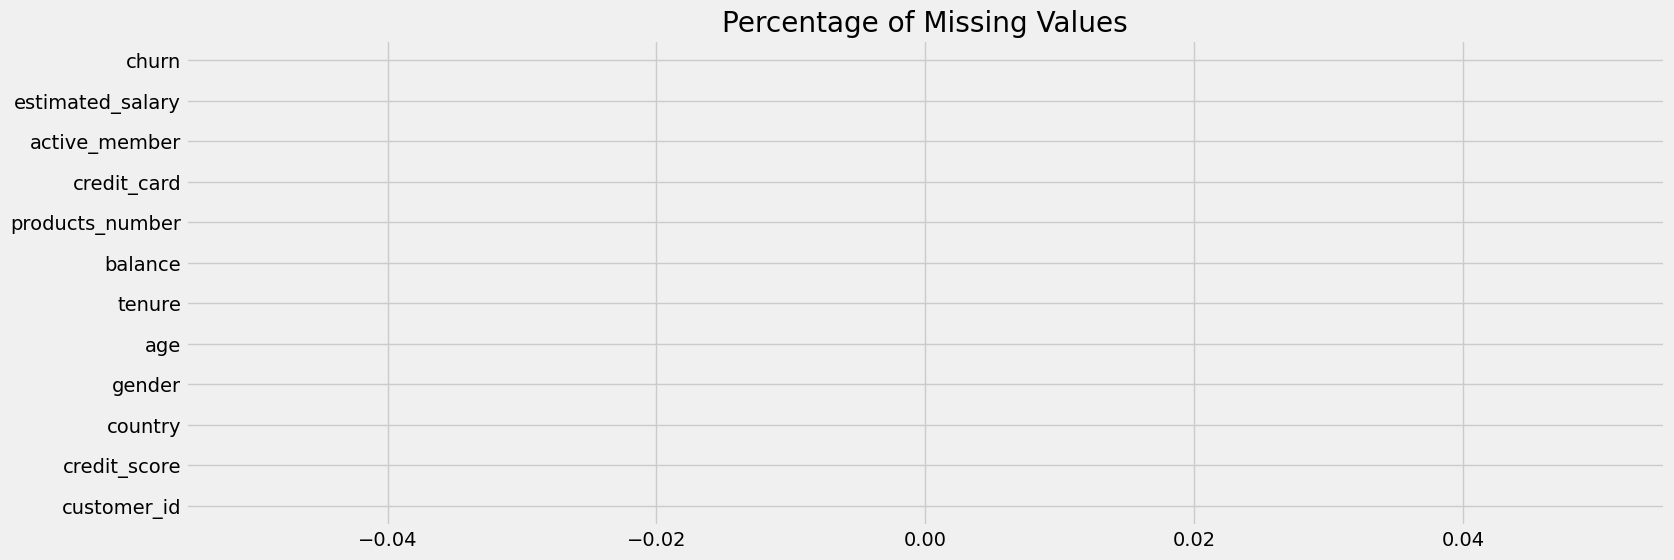

In [7]:
plt.style.use('fivethirtyeight')
display(df.isna().sum()/len(df)*100)
(df.isna().sum()/len(df)*100).plot(kind = 'barh', figsize = (17,6));
plt.title('Percentage of Missing Values')
plt.show()

churn
0    79.63
1    20.37
Name: count, dtype: float64

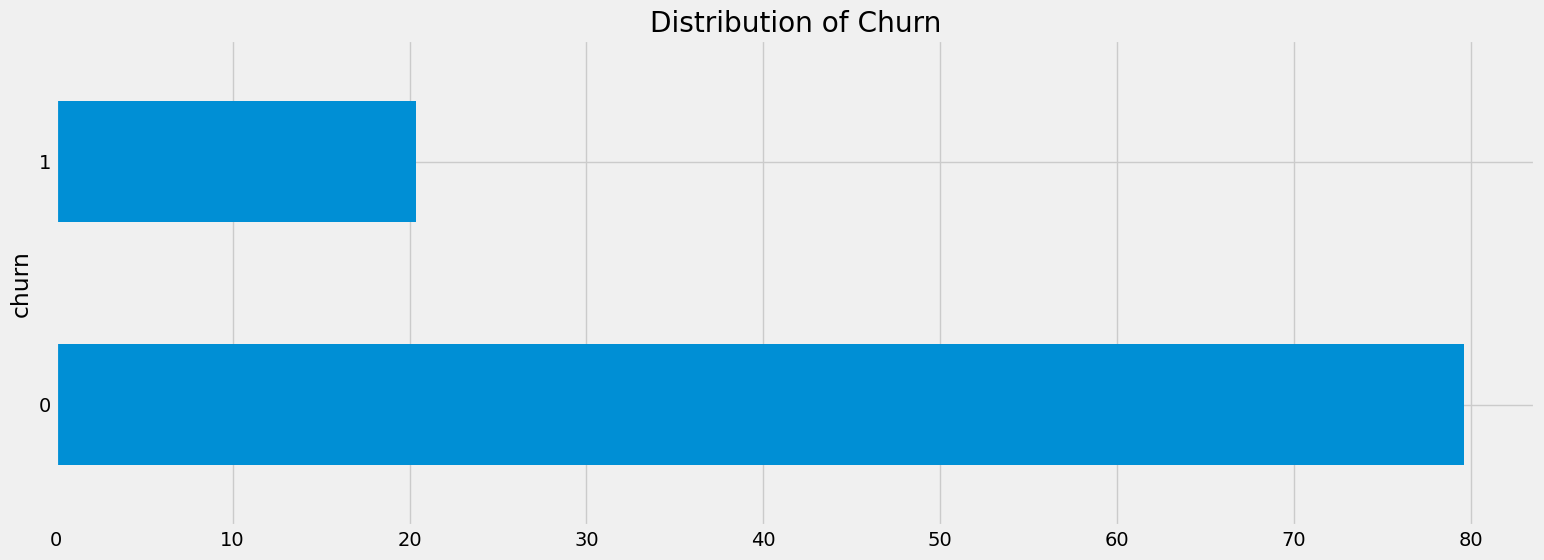

In [8]:
display(df['churn'].value_counts()/len(df)*100)
(df['churn'].value_counts()/len(df)*100).plot(kind = 'barh', figsize = (17,6));
plt.title('Distribution of Churn')
plt.show()
# data is imbalanced

Feature Engineering

In [9]:
finalDF = df.copy()
finalDF = finalDF.drop_duplicates()
print("Shape of Combined Dataframe : ", finalDF.shape)

Shape of Combined Dataframe :  (10000, 12)


In [10]:
finalDF.drop_duplicates(subset='customer_id', keep='last', inplace=True, ignore_index=False)
print("Shape of Combined Dataframe : ", finalDF.shape)

Shape of Combined Dataframe :  (10000, 12)


churn
0    79.63
1    20.37
Name: count, dtype: float64

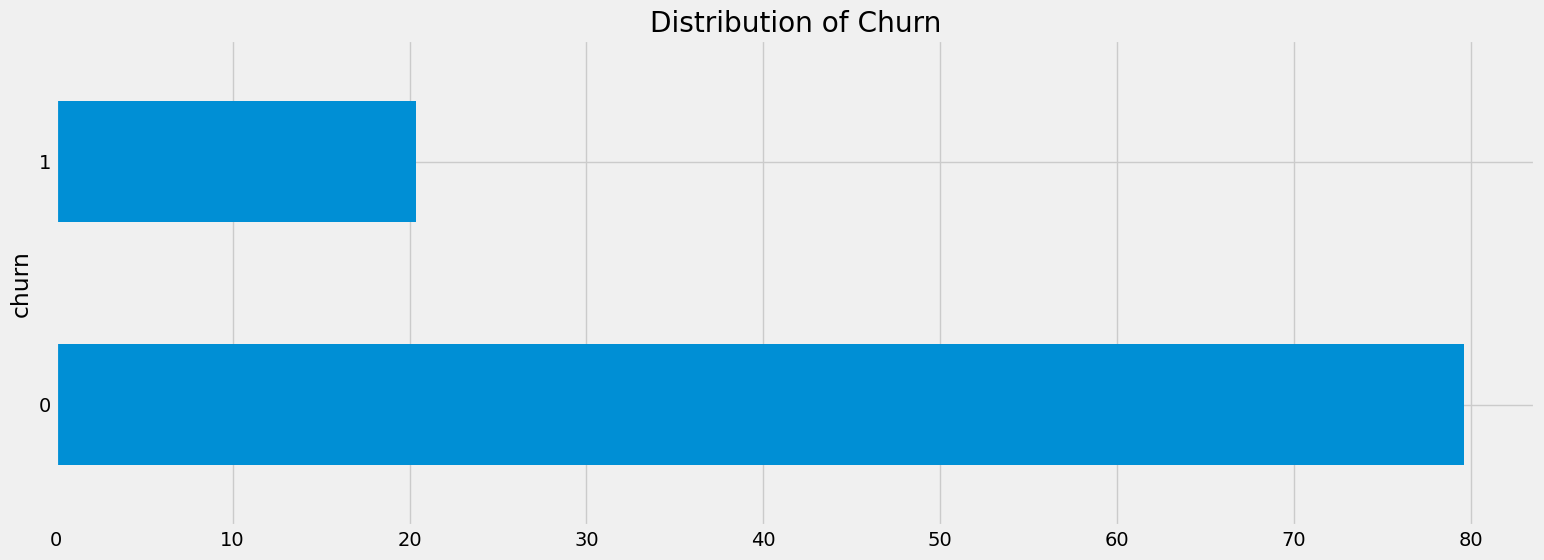

In [11]:
display(finalDF['churn'].value_counts()/len(finalDF)*100)
(finalDF['churn'].value_counts()/len(finalDF)*100).plot(kind = 'barh', figsize = (17,6));
plt.title('Distribution of Churn')
plt.show();

In [12]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [13]:
finalDF.drop(['customer_id'], axis=1, inplace=True)
finalDF.drop(['products_number'], axis=1, inplace=True)

In [14]:
categoricals = find_categorical(finalDF)

In [15]:
summarize_categoricals(finalDF[categoricals], show_levels=True)

,Levels,No. of Levels,No. of Missing Values
country,"[France, Spain, Germany]",3,0
gender,"[Female, Male]",2,0
credit_card,"[1, 0]",2,0
active_member,"[1, 0]",2,0
churn,"[1, 0]",2,0


In [16]:
numericals = list(set(finalDF.columns.tolist()) - set(categoricals)) + list(set(categoricals) - set(finalDF.columns.tolist()))

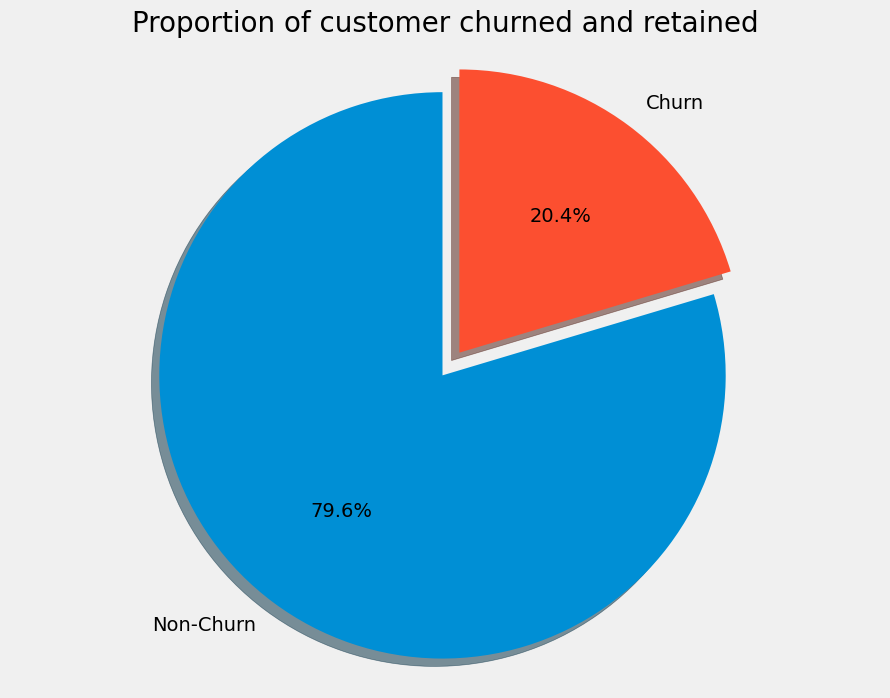

In [17]:
labels = 'Non-Churn', 'Churn'
sizes = [finalDF.churn[finalDF['churn']==0].count(), finalDF.churn[finalDF['churn']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
finalDF.head()

,credit_score,country,gender,age,tenure,balance,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,1,0,113931.57,1
3,699,France,Female,39,1,0.00,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


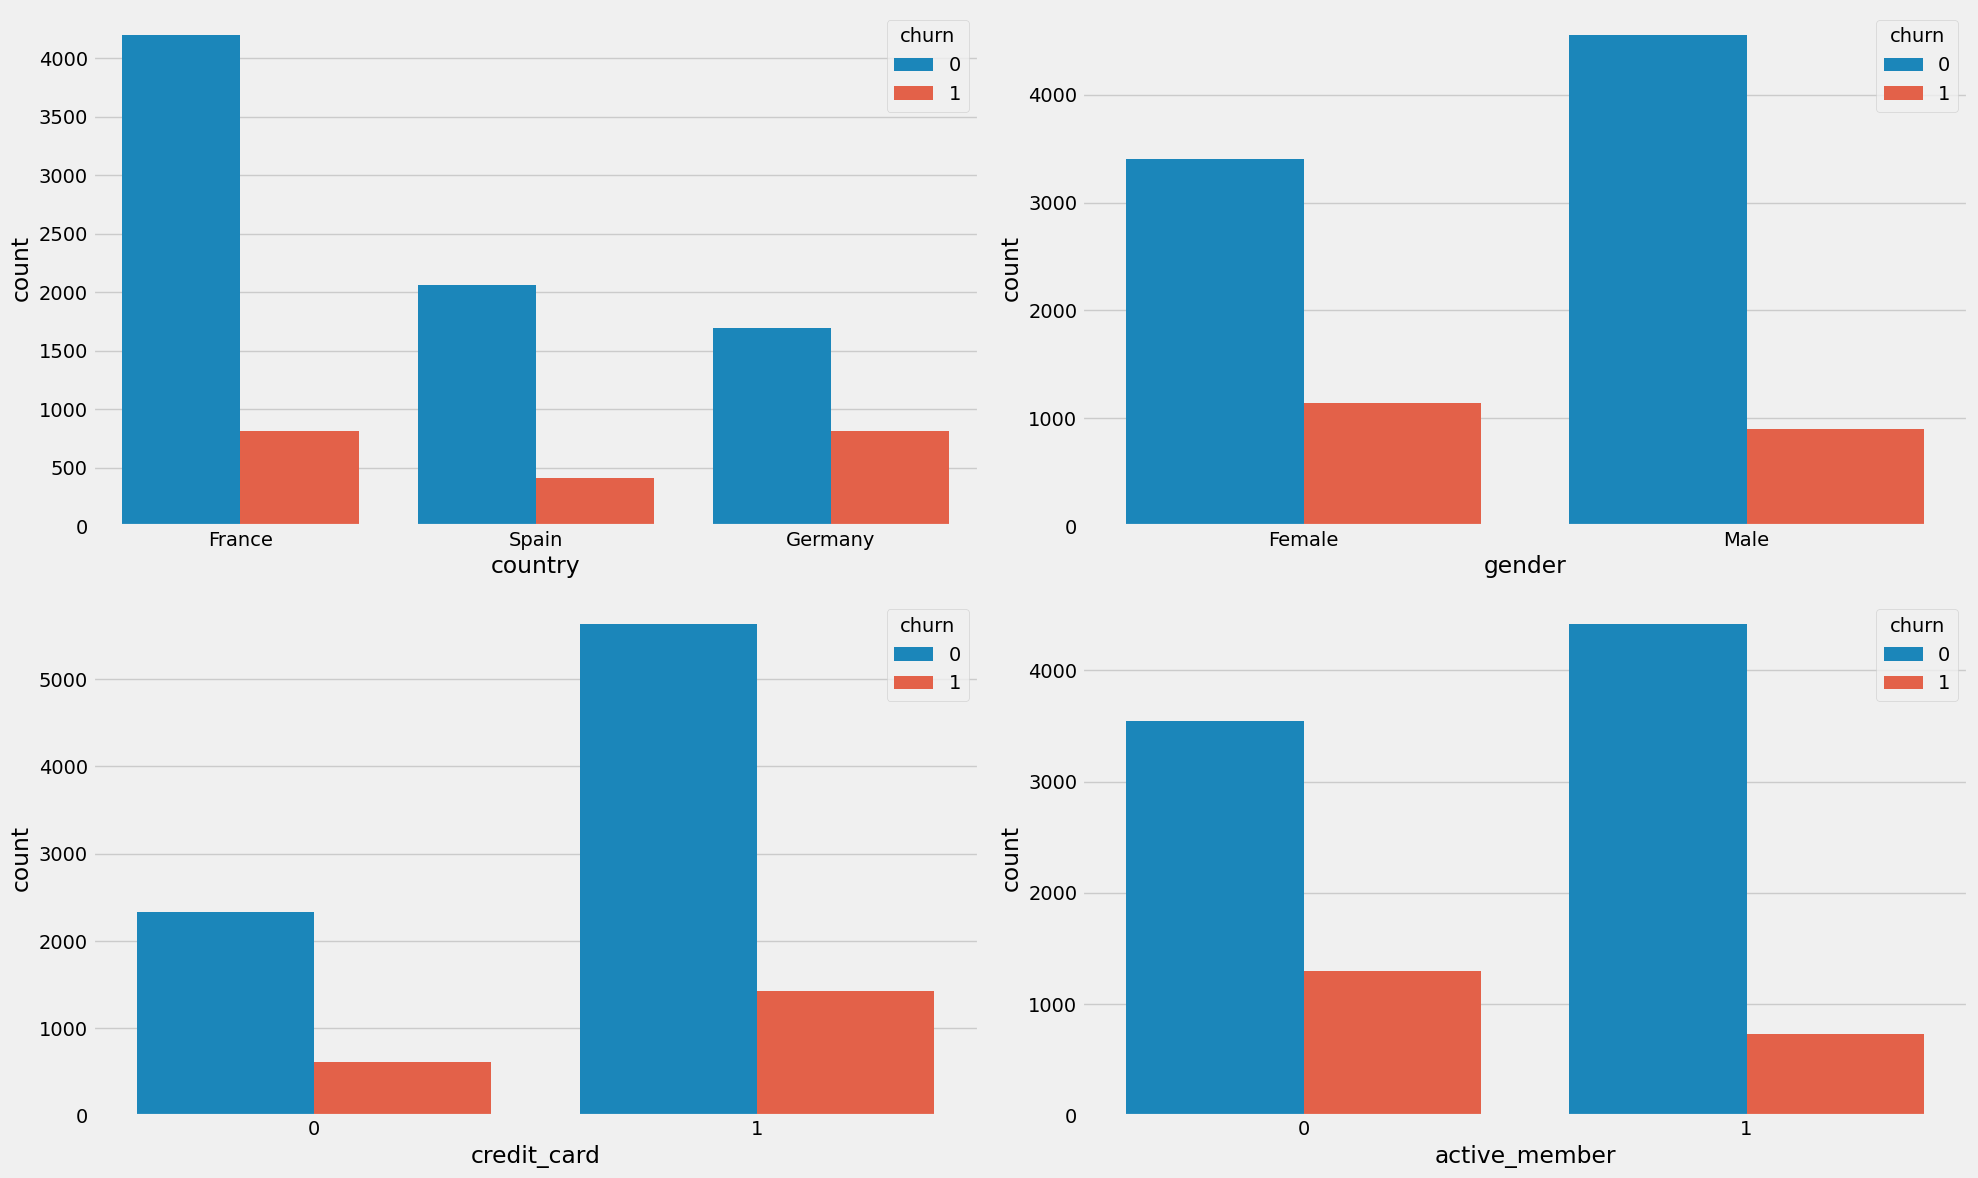

In [19]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='country', hue = 'churn',data = finalDF, ax=axarr[0][0])
sns.countplot(x='gender', hue = 'churn',data = finalDF, ax=axarr[0][1])
sns.countplot(x='credit_card', hue = 'churn',data = finalDF, ax=axarr[1][0])
sns.countplot(x='active_member', hue = 'churn',data = finalDF, ax=axarr[1][1])
plt.tight_layout()
plt.show();

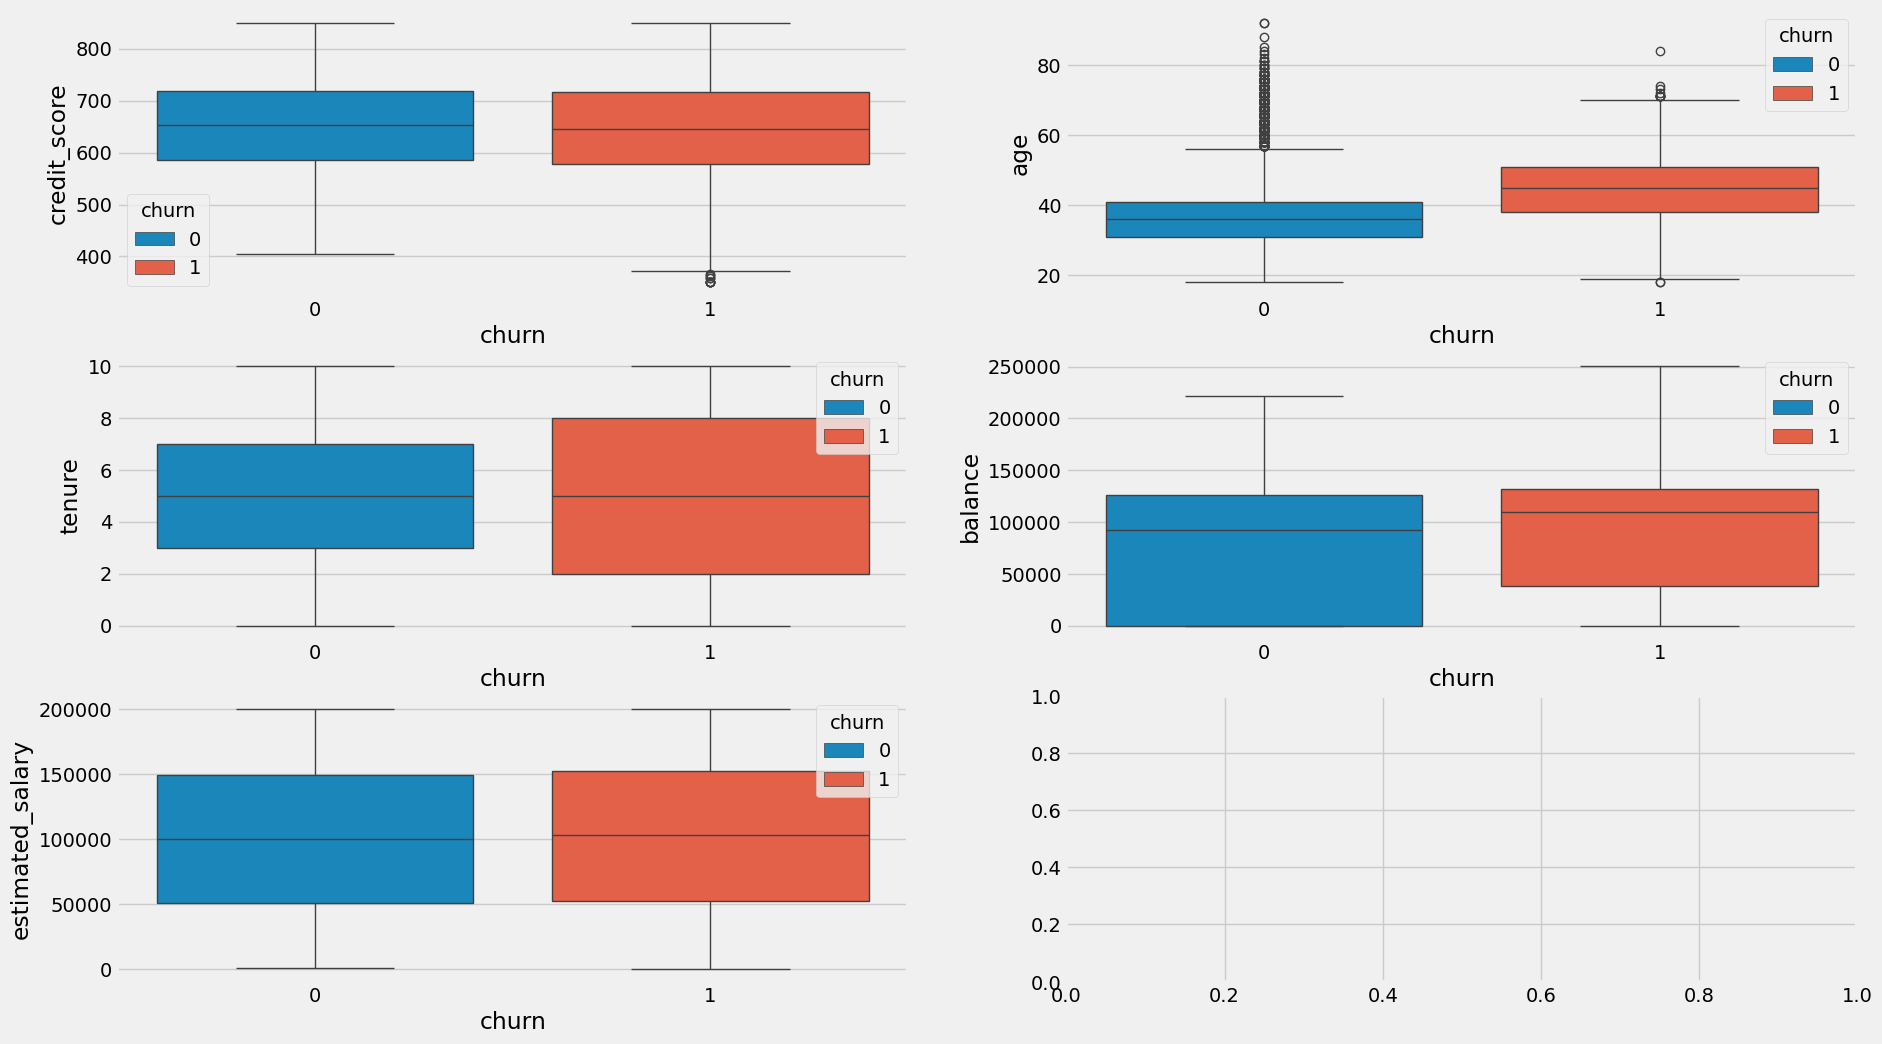

In [20]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='credit_score',x = 'churn', hue = 'churn',data = finalDF, ax=axarr[0][0])
sns.boxplot(y='age',x = 'churn', hue = 'churn',data = finalDF , ax=axarr[0][1])
sns.boxplot(y='tenure',x = 'churn', hue = 'churn',data = finalDF, ax=axarr[1][0])
sns.boxplot(y='balance',x = 'churn', hue = 'churn',data = finalDF, ax=axarr[1][1])
sns.boxplot(y='estimated_salary',x = 'churn', hue = 'churn',data = finalDF, ax=axarr[2][0])
plt.show();

C:\Users\LEGION\AppData\Local\Temp\ipykernel_10740\2703084532.py:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
C:\Users\LEGION\AppData\Local\Temp\ipykernel_10740\2703084532.py:15: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
C:\Users\LEGION\AppData\Local\Temp\ipykernel_10740\2703084532.py:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0

<Figure size 640x480 with 0 Axes>

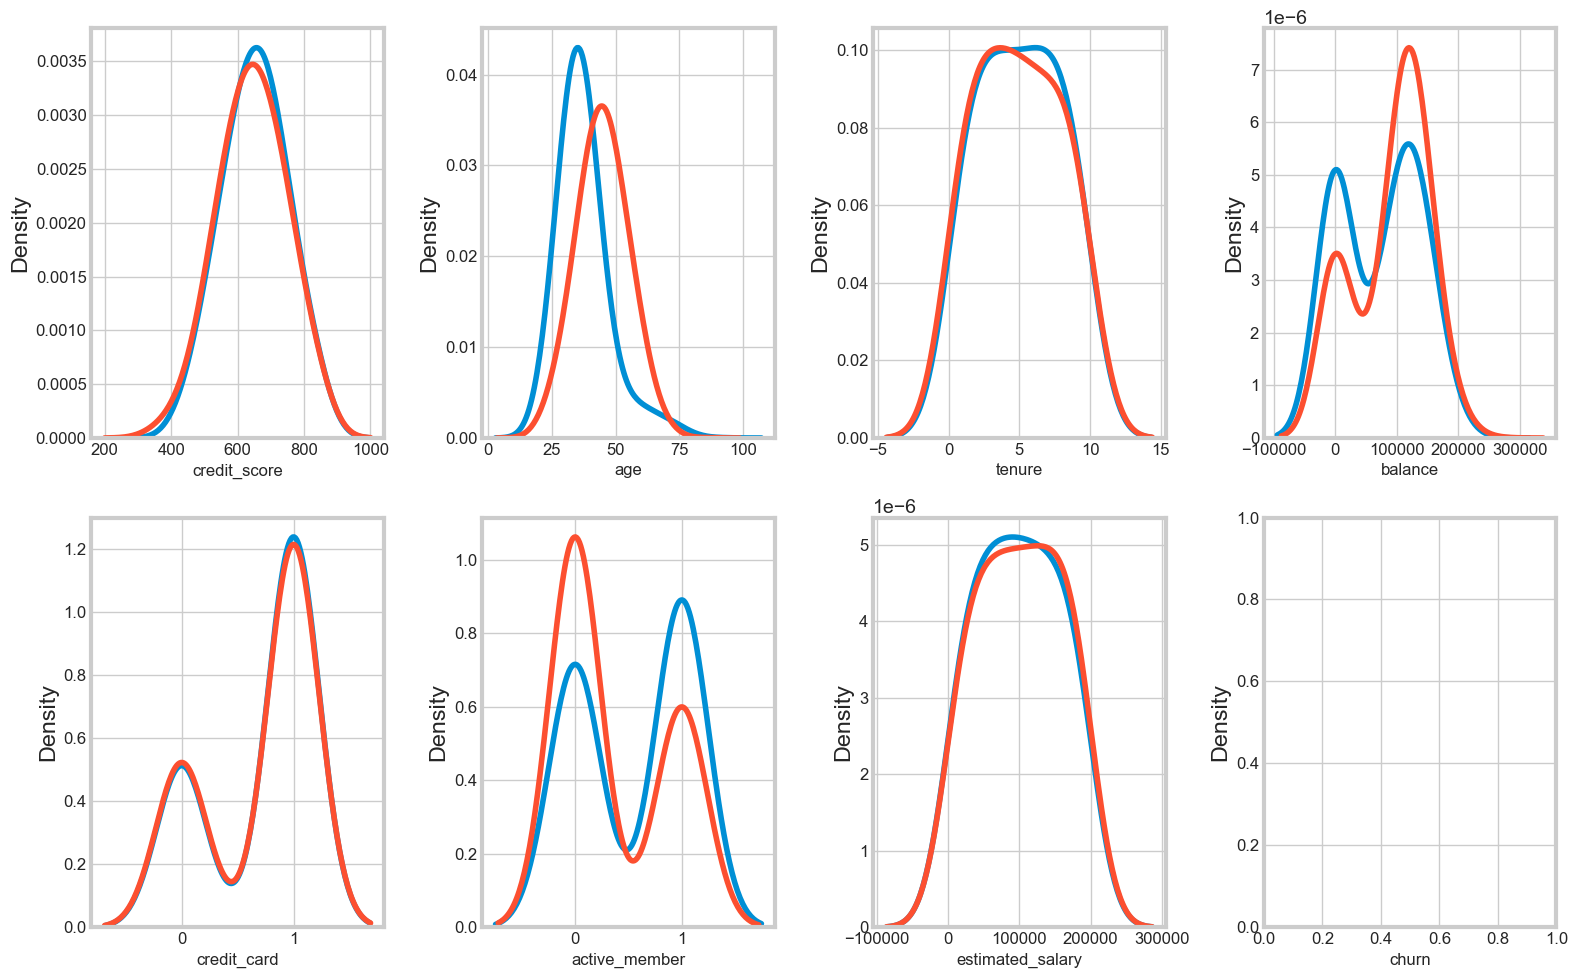

In [21]:
var = finalDF.select_dtypes(include=['float64', 'int']).columns.tolist()

i = 0
t0 = finalDF.loc[finalDF['churn'] == 0]
t1 = finalDF.loc[finalDF['churn'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,4,figsize=(16,10))

for feature in var:
    i += 1
    plt.subplot(2,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show();

Check for correlation between Quantita. variables

In [22]:
numericals = list(set(finalDF.columns.tolist()) - set(categoricals)) + list(set(categoricals) - set(finalDF.columns.tolist()))

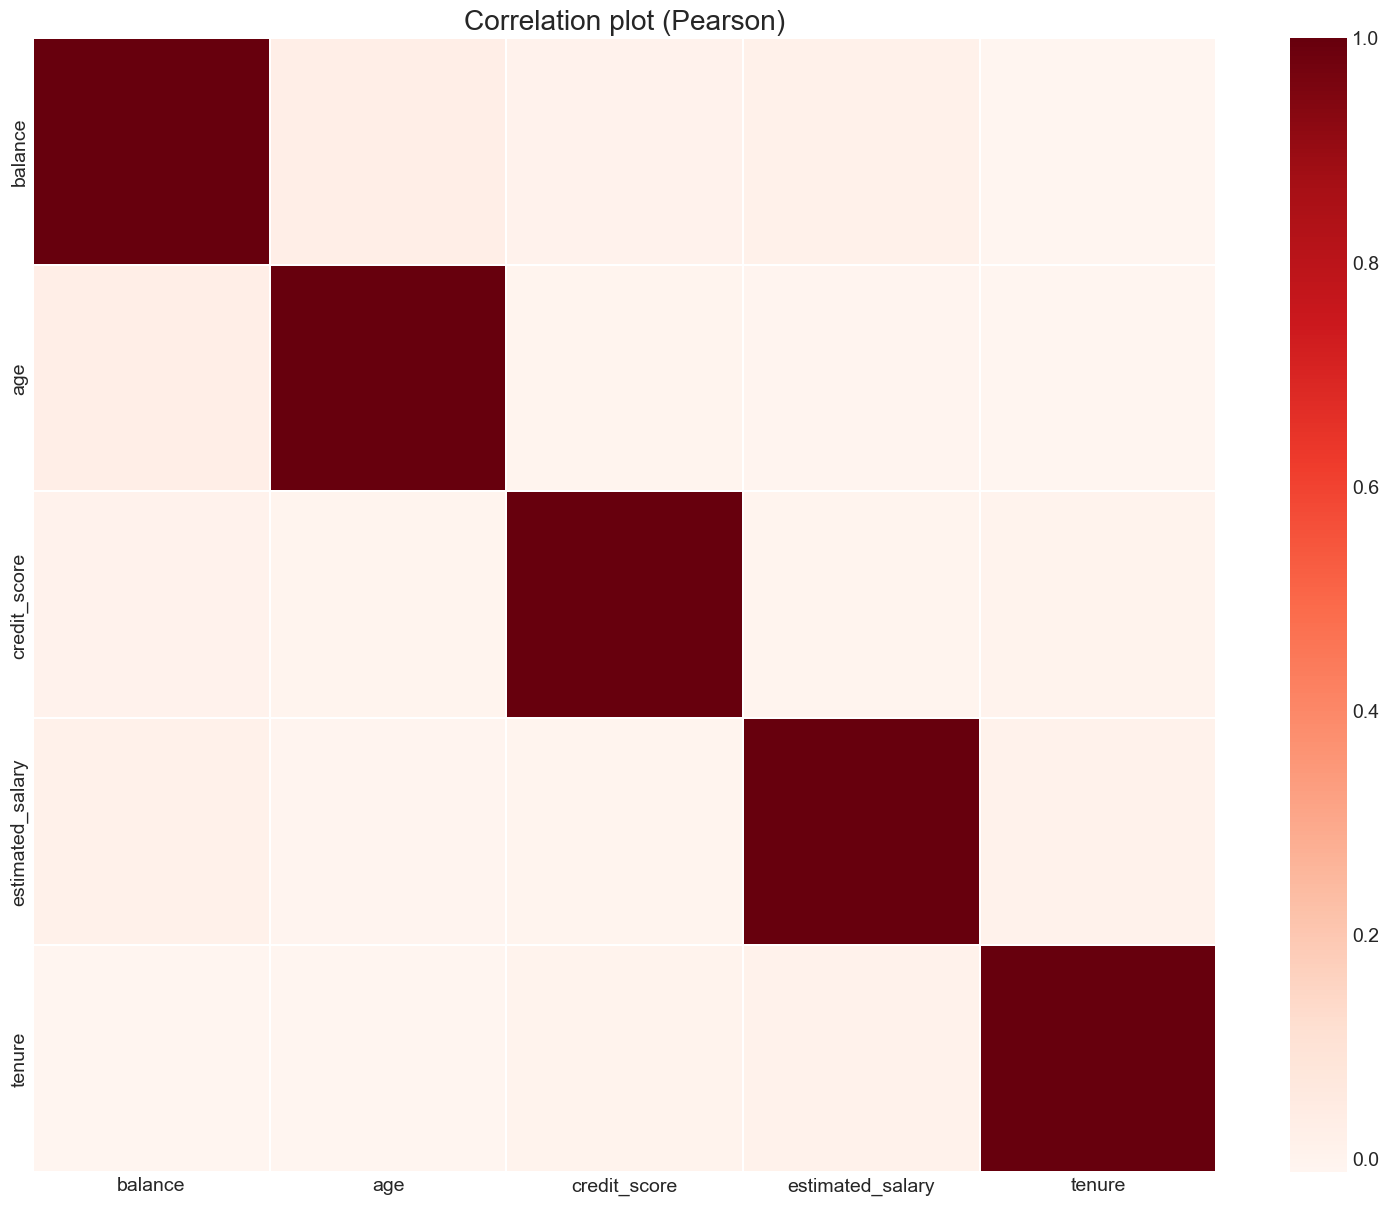

In [23]:
plt.figure(figsize = (17,14))
plt.title('Correlation plot (Pearson)')
corr = finalDF[numericals].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show();

In [24]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(axis=1)\
    .set_properties(**{'max-width': '100px', 'font-size': '15pt'})\
    .set_caption("Hover to magify")\
    .set_table_styles(magnify())

,balance,age,credit_score,estimated_salary,tenure
balance,1.000000,0.028308,0.006268,0.012797,-0.012254
age,0.028308,1.000000,-0.003965,-0.007201,-0.009997
credit_score,0.006268,-0.003965,1.000000,-0.001384,0.000842
estimated_salary,0.012797,-0.007201,-0.001384,1.000000,0.007784
tenure,-0.012254,-0.009997,0.000842,0.007784,1.000000


There isn't much to be done, since the dataset is so uncorrelated

In [25]:
final_data = finalDF.copy()

In [26]:
final_data.head(5)

,credit_score,country,gender,age,tenure,balance,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,1,0,113931.57,1
3,699,France,Female,39,1,0.00,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


In [27]:
# # One-hot encoding
# def one_hot_encoding(df, cols):
#     """
#     @param df pandas DataFrame
#     @param cols a list of columns to encode
#     @return a DataFrame with one-hot encoding
#     """
#     for each in cols:
#         dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
#         df = pd.concat([df, dummies], axis=1)
#         df = df.drop(each, 1)
#     return df

# # Function to min-max normalize
# def normalize(df, cols):
#     """
#     @param df pandas DataFrame
#     @param cols a list of columns to encode
#     @return a DataFrame with normalized specified features
#     """
#     result = df.copy() # do not touch the original df
#     for feature_name in cols:
#         max_value = df[feature_name].max()
#         min_value = df[feature_name].min()
#         if max_value > min_value:
#             result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#     return result

In [28]:
# One-hot encoding
def one_hot_encoding(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, axis=1)
    return df

# Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [29]:
print(categoricals)

['country', 'gender', 'credit_card', 'active_member', 'churn']


In [30]:
categoricals.remove('churn')

In [31]:
one_hot_finalDF = one_hot_encoding(finalDF, categoricals)
# one_hot_final is the version that replaces ALL categoricals w one hot ver

In [32]:
one_hot_finalDF.head(5)

,credit_score,age,tenure,balance,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male,credit_card_0,credit_card_1,active_member_0,active_member_1
0,619,42,2,0.00,101348.88,1,True,False,False,True,False,False,True,False,True
1,608,41,1,83807.86,112542.58,0,False,False,True,True,False,True,False,False,True
2,502,42,8,159660.80,113931.57,1,True,False,False,True,False,False,True,True,False
3,699,39,1,0.00,93826.63,0,True,False,False,True,False,True,False,True,False
4,850,43,2,125510.82,79084.10,0,False,False,True,True,False,False,True,False,True


In [33]:
one_hot_finalDF.shape

(10000, 15)

In [34]:
finalDF = one_hot_finalDF

In [35]:
finalDF = finalDF.dropna()
finalDF.reset_index(inplace = True, drop = True)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = list(finalDF.dtypes[finalDF.dtypes != 'object'].index)
numeric_cols.remove('churn')
finalDF.loc[:,numeric_cols] = scaler.fit_transform(finalDF.loc[:,numeric_cols])

In [37]:
finalDF.head()

,credit_score,age,tenure,balance,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male,credit_card_0,credit_card_1,active_member_0,active_member_1
0,-0.326221,0.293517,-1.041760,-1.225848,0.021886,1,0.997204,-0.578736,-0.573809,1.095988,-1.095988,-0.646092,0.646092,-0.970243,0.970243
1,-0.440036,0.198164,-1.387538,0.117350,0.216534,0,-1.002804,-0.578736,1.742740,1.095988,-1.095988,1.547768,-1.547768,-0.970243,0.970243
2,-1.536794,0.293517,1.032908,1.333053,0.240687,1,0.997204,-0.578736,-0.573809,1.095988,-1.095988,-0.646092,0.646092,1.030670,-1.030670
3,0.501521,0.007457,-1.387538,-1.225848,-0.108918,0,0.997204,-0.578736,-0.573809,1.095988,-1.095988,1.547768,-1.547768,1.030670,-1.030670
4,2.063884,0.388871,-1.041760,0.785728,-0.365276,0,-1.002804,-0.578736,1.742740,1.095988,-1.095988,-0.646092,0.646092,-0.970243,0.970243


In [38]:
finalDF['churn'] = finalDF['churn'].astype('object')
x = finalDF.drop(['churn'], axis = 1)
y = finalDF['churn']

categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

In [39]:
y.head(5)

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: object

In [40]:
from sklearn.model_selection import train_test_split


In [41]:
from sklearn.metrics import cohen_kappa_score
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, shuffle=True)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train = X_train.fillna(method='ffill')
X_test = X_test.fillna(method='ffill')

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
# Y_train = y_train.copy()
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
Y_train = y_train.copy()


In [43]:
print('Train data shape: {}'.format(X_train.shape))
print('Test data shape: {}'.format(X_test.shape))

Train data shape: (12646, 14)
Test data shape: (2000, 14)


In [44]:
y_train.value_counts()

churn
0    6323
1    6323
Name: count, dtype: int64

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

train_accuracy = []
test_accuracy = []
precision = []
recall = []
f1 = []
cohen_kappa = []
models = ["Naive Bayes","Logistic Regression","Decision Tree","RandomForest", "AdaBoost", "ExtraTrees","GradientBoosting","XGboost"]
roc = []
mathew = []
random_state = 2
classifiers = []
classifiers.append(BernoulliNB())
classifiers.append(LogisticRegression())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier(random_state=random_state, max_depth = 10, max_features = 'sqrt', n_estimators=  300))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.5))
classifiers.append(ExtraTreesClassifier(random_state=random_state, criterion ='entropy', max_features = 'sqrt', min_samples_leaf = 20, min_samples_split = 15))
classifiers.append(GradientBoostingClassifier(random_state=random_state, learning_rate = 0.2, max_depth = 10, n_estimators = 200))
classifiers.append(XGBClassifier(random_state = random_state))



for classifier,model in zip(classifiers, models):
    print('='*len(model))
    print(model)
    print('='*len(model))
    classifier.fit(X_train, y_train)
    trainprediction = classifier.predict(X_train)
    prediction = classifier.predict(X_test)
    trainaccuracy = accuracy_score(y_train, trainprediction)
    testaccuracy = accuracy_score(y_test, prediction)
    train_accuracy.append(trainaccuracy)
    test_accuracy.append(testaccuracy)
    precision.append(precision_score(y_test, prediction, average='macro'))
    recall.append(recall_score(y_test, prediction, average='macro'))
    cohen_kappa.append(cohen_kappa_score(y_test, prediction))
    f1.append(f1_score(y_test, prediction, average='macro'))
    roc.append(metrics.roc_auc_score(y_test, prediction))

    mathew.append(metrics.matthews_corrcoef(y_test, prediction))

    print('\n clasification report:\n', classification_report(y_test,prediction))
    print('\n confussion matrix:\n',confusion_matrix(y_test, prediction))
    print('\n')
    
scoreDF = pd.DataFrame({'Model' : models})
scoreDF['Train Accuracy'] = train_accuracy
scoreDF['Test Accuracy'] = test_accuracy
scoreDF['Precision'] =  precision
scoreDF['Recall'] =  recall
scoreDF['F1 Score'] = f1 
scoreDF['AUC Score'] = roc 
scoreDF['Matthew Correlation Coefficient'] = mathew
scoreDF['Cohen Kappa Score'] = cohen_kappa


scoreDF.set_index("Model")

Naive Bayes

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.77      1640
           1       0.32      0.72      0.45       360

    accuracy                           0.68      2000
   macro avg       0.62      0.69      0.61      2000
weighted avg       0.81      0.68      0.72      2000


 confussion matrix:
 [[1099  541]
 [ 101  259]]


Logistic Regression

 clasification report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1640
           1       0.34      0.68      0.45       360

    accuracy                           0.70      2000
   macro avg       0.62      0.69      0.62      2000
weighted avg       0.81      0.70      0.73      2000


 confussion matrix:
 [[1159  481]
 [ 115  245]]


Decision Tree



 clasification report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1640
           1       0.33      0.46      0.38       360

    accuracy                           0.73      2000
   macro avg       0.60      0.62      0.60      2000
weighted avg       0.77      0.73      0.75      2000


 confussion matrix:
 [[1301  339]
 [ 196  164]]


RandomForest

 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      1640
           1       0.41      0.61      0.49       360

    accuracy                           0.77      2000
   macro avg       0.66      0.71      0.67      2000
weighted avg       0.82      0.77      0.79      2000


 confussion matrix:
 [[1327  313]
 [ 141  219]]


AdaBoost

 clasification report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1640
           1       0.34      0.47     

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC Score,Matthew Correlation Coefficient,Cohen Kappa Score
Model,,,,,,,,
Naive Bayes,0.700459,0.6790,0.619792,0.694783,0.610248,0.694783,0.305506,0.263761
Logistic Regression,0.720228,0.7020,0.623599,0.693631,0.623334,0.693631,0.309404,0.277260
Decision Tree,1.000000,0.7325,0.597558,0.624424,0.604762,0.624424,0.220350,0.215450
RandomForest,0.871264,0.7730,0.657803,0.708740,0.672478,0.708740,0.362986,0.351873
AdaBoost,1.000000,0.7405,0.607617,0.636890,0.615937,0.636890,0.242748,0.237482
ExtraTrees,0.752807,0.7260,0.634077,0.701762,0.640812,0.701762,0.328947,0.303012
GradientBoosting,1.000000,0.8315,0.709818,0.669614,0.685375,0.669614,0.377296,0.372767
XGboost,0.951842,0.8370,0.721970,0.700068,0.709838,0.700068,0.421469,0.420176


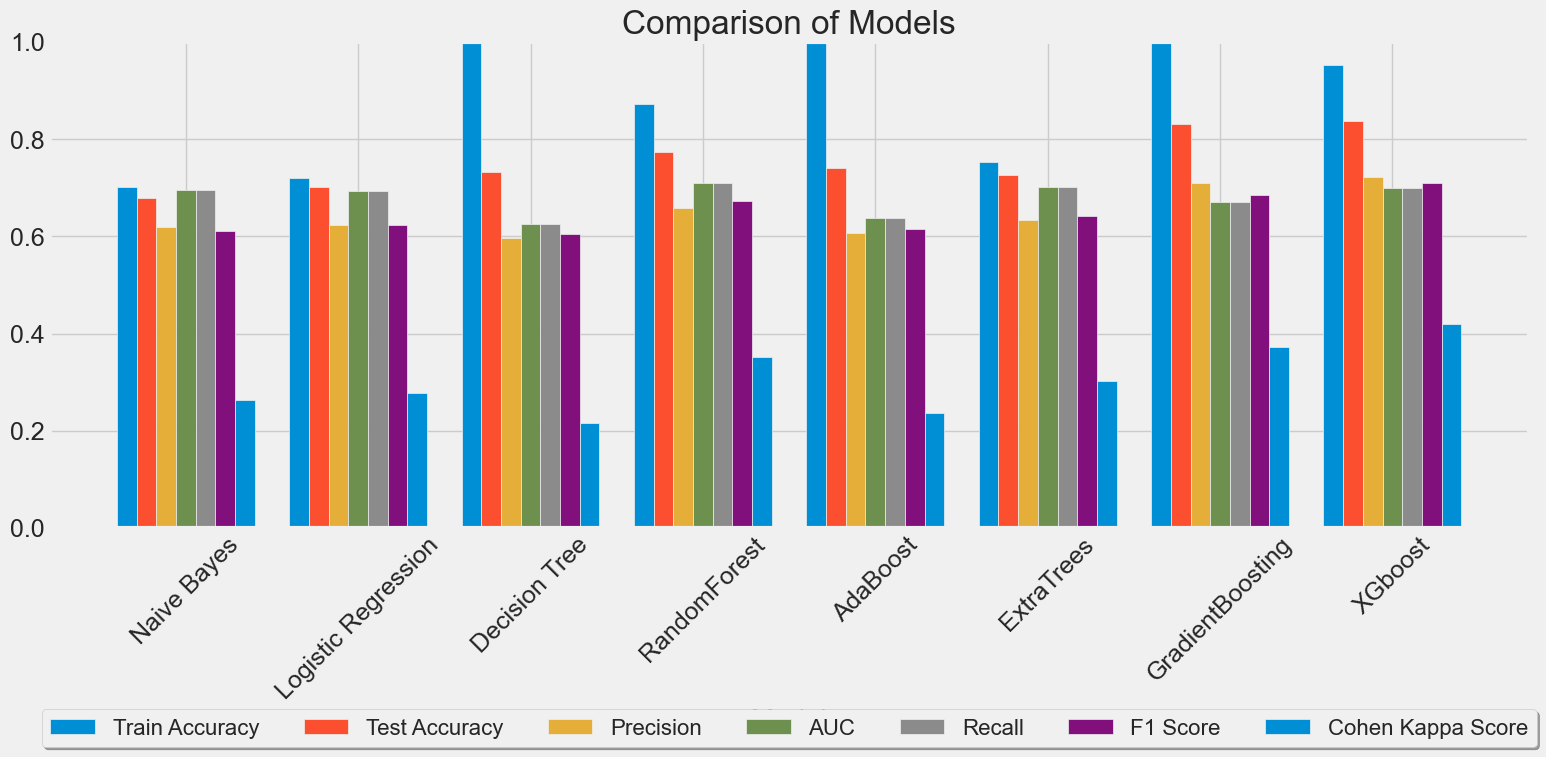

In [46]:
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': '16',
          'figure.figsize': (15, 5),
         'axes.labelsize': '20',
         'axes.titlesize':'30',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18'}
plt.rcParams.update(params)

def subcategorybar(X, vals, width=0.8):
    cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'AUC Score','Recall','F1 Score', 'Cohen Kappa Score']
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
        
        
    plt.xticks(_X, X)
    
plt.figure(figsize = (17,6))
subcategorybar(models, [scoreDF['Train Accuracy'], scoreDF['Test Accuracy'], scoreDF['Precision'], scoreDF['AUC Score'], scoreDF['Recall'], scoreDF['F1 Score'], scoreDF['Cohen Kappa Score']])
plt.ylim(0, 1.0)
cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'AUC','Recall','F1 Score', 'Cohen Kappa Score']
#plt.legend(cols)

plt.legend(cols, loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=True, ncol=7)


plt.xlabel('Model', fontsize = 20)
plt.xticks(rotation = 45)

plt.title("Comparison of Models", fontsize = 24)
plt.show();

In [47]:
scoreDF = scoreDF.set_index("Model")

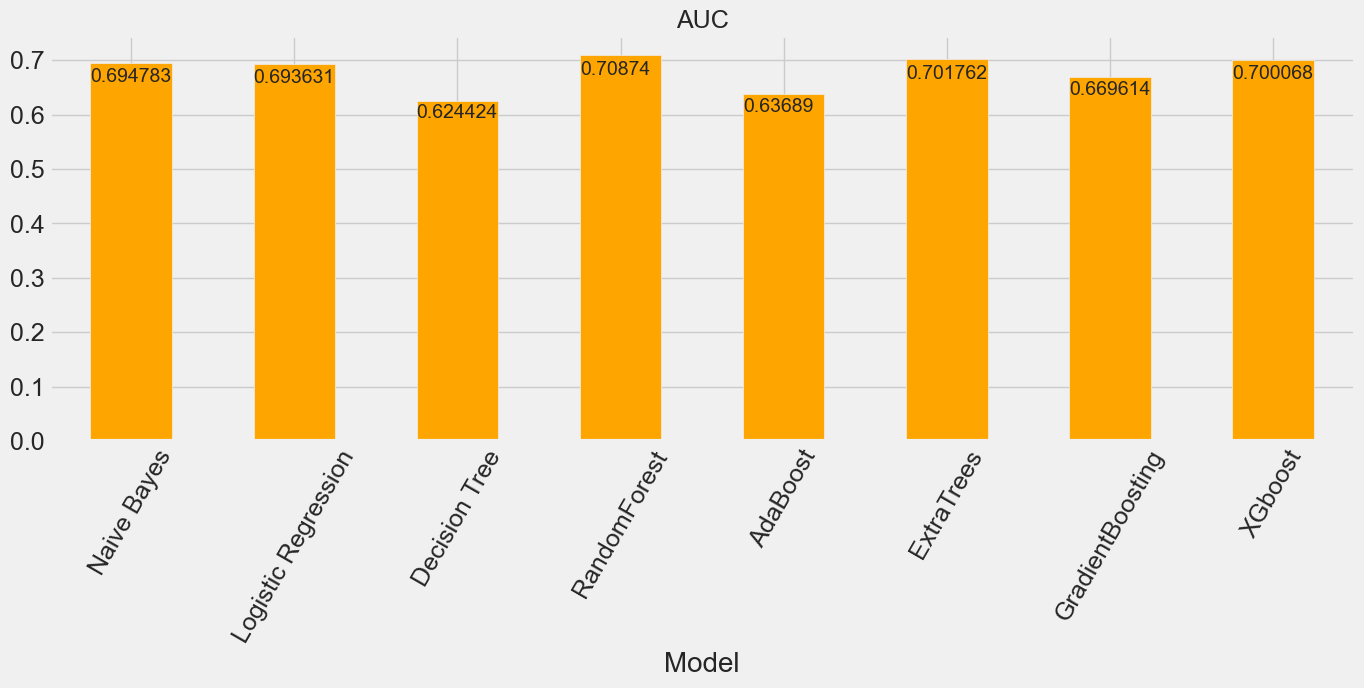

In [48]:
# replace scoreDF index as needed for the needed visualization
ax = scoreDF['AUC Score'].round(6).plot(kind = 'bar', color = 'orange');

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1., p.get_height() * 0.95))
plt.title('AUC', fontsize = 18)
plt.xticks(rotation = 60)
plt.show();

Now for some weighted averaging

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

ensemble = VotingClassifier(estimators=[('Logistic Regression', LogisticRegression(random_state = random_state)),
                                              ('Naive Bayes', GaussianNB()),
                                              ('RF', RandomForestClassifier(random_state=random_state)),
                                              ('KNN', KNeighborsClassifier()),
                                              ('Decision Tree', DecisionTreeClassifier(random_state=random_state))], 
                                               voting='hard').fit(X_train,y_train)

In [50]:
y_train_ensemble = ensemble.predict(X_train)
y_pred_ensemble = ensemble.predict(X_test)

trainaccuracy = accuracy_score(y_train, y_train_ensemble)
testaccuracy = accuracy_score(y_test, y_pred_ensemble)
train_accuracy.append(trainaccuracy)
test_accuracy.append(testaccuracy)
precision.append(precision_score(y_test, y_pred_ensemble, average='macro'))
recall.append(recall_score(y_test, y_pred_ensemble, average='macro'))
cohen_kappa.append(cohen_kappa_score(y_test, y_pred_ensemble))
f1.append(f1_score(y_test, y_pred_ensemble, average='macro'))
roc.append(metrics.roc_auc_score(y_test, y_pred_ensemble))
mathew.append(metrics.matthews_corrcoef(y_test, y_pred_ensemble))


 Accuracy Score:
 0.76

 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.84      1640
           1       0.39      0.60      0.47       360

    accuracy                           0.76      2000
   macro avg       0.65      0.70      0.66      2000
weighted avg       0.81      0.76      0.78      2000


 Cohen Kappa Score:
 0.3270524899057873


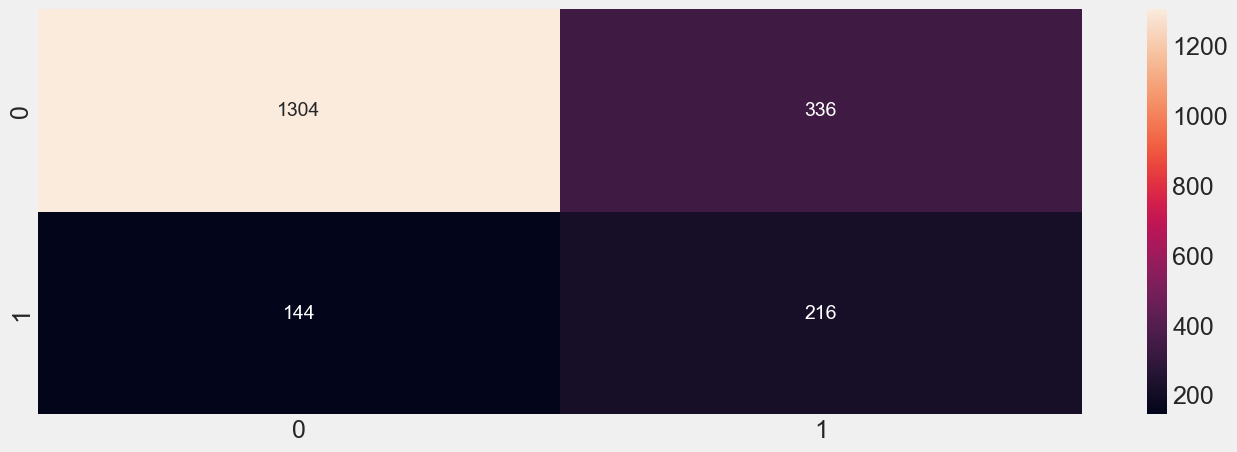

In [51]:
print('\n Accuracy Score:\n', np.round(accuracy_score(y_test, y_pred_ensemble), 3))
sns.heatmap(confusion_matrix(y_test,y_pred_ensemble),annot=True,fmt='2.0f')
print('\n clasification report:\n', classification_report(y_test,y_pred_ensemble))
print('\n Cohen Kappa Score:\n', metrics.cohen_kappa_score(y_test, y_pred_ensemble))

plt.show()


 Accuracy Score:
 0.772

 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.85      1640
           1       0.40      0.57      0.47       360

    accuracy                           0.77      2000
   macro avg       0.65      0.69      0.66      2000
weighted avg       0.81      0.77      0.79      2000


 Cohen Kappa Score:
 0.3323398784478728


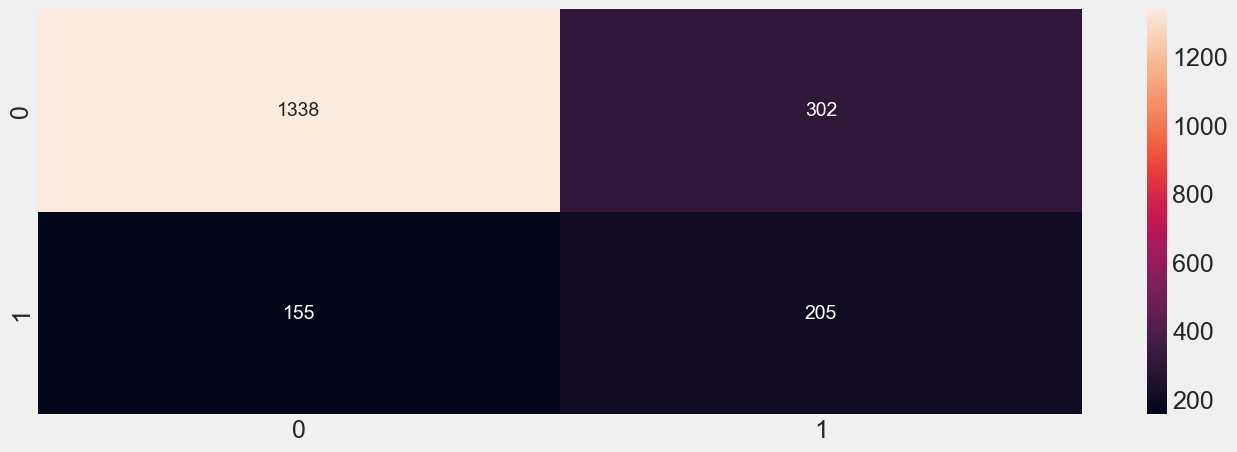

In [52]:
ensemble2 = VotingClassifier(estimators=[('Logistic Regression', LogisticRegression(random_state = random_state)),
                                              ('Naive Bayes', GaussianNB()),
                                              ('RF', RandomForestClassifier(random_state=random_state)),
                                              ('KNN', KNeighborsClassifier()),
                                              ('Decision Tree', DecisionTreeClassifier(random_state=random_state))], 
                                               voting='soft').fit(X_train,y_train)

y_train_ensemble2 = ensemble2.predict(X_train)
y_pred_ensemble2 = ensemble2.predict(X_test)

trainaccuracy = accuracy_score(y_train, y_train_ensemble2)
testaccuracy = accuracy_score(y_test, y_pred_ensemble2)
train_accuracy.append(trainaccuracy)
test_accuracy.append(testaccuracy)
precision.append(precision_score(y_test, y_pred_ensemble2, average='macro'))
recall.append(recall_score(y_test, y_pred_ensemble2, average='macro'))
cohen_kappa.append(cohen_kappa_score(y_test, y_pred_ensemble2))
f1.append(f1_score(y_test, y_pred_ensemble2, average='macro'))
roc.append(metrics.roc_auc_score(y_test, y_pred_ensemble2))
mathew.append(metrics.matthews_corrcoef(y_test, y_pred_ensemble2))

print('\n Accuracy Score:\n', np.round(accuracy_score(y_test, y_pred_ensemble2), 3))
sns.heatmap(confusion_matrix(y_test,y_pred_ensemble2),annot=True,fmt='2.0f')
print('\n clasification report:\n', classification_report(y_test,y_pred_ensemble2))
print('\n Cohen Kappa Score:\n', metrics.cohen_kappa_score(y_test, y_pred_ensemble2))
plt.show()

In [53]:
models.append('Stack Ensemble (Hard Voting)')
models.append('Stack Ensemble (Soft Voting)')
scoreDF = pd.DataFrame({'Model' : models})
scoreDF['Train Accuracy'] = train_accuracy
scoreDF['Test Accuracy'] = test_accuracy
scoreDF['Precision'] =  precision
scoreDF['Recall'] =  recall
scoreDF['F1 Score'] = f1 
scoreDF['AUC Score'] = roc 
scoreDF['Matthew Correlation Coefficient'] = mathew
scoreDF['Cohen Kappa Score'] = cohen_kappa

scoreDF = scoreDF.set_index("Model")

In [54]:
scoreDF

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC Score,Matthew Correlation Coefficient,Cohen Kappa Score
Model,,,,,,,,
Naive Bayes,0.700459,0.6790,0.619792,0.694783,0.610248,0.694783,0.305506,0.263761
Logistic Regression,0.720228,0.7020,0.623599,0.693631,0.623334,0.693631,0.309404,0.277260
Decision Tree,1.000000,0.7325,0.597558,0.624424,0.604762,0.624424,0.220350,0.215450
RandomForest,0.871264,0.7730,0.657803,0.708740,0.672478,0.708740,0.362986,0.351873
AdaBoost,1.000000,0.7405,0.607617,0.636890,0.615937,0.636890,0.242748,0.237482
ExtraTrees,0.752807,0.7260,0.634077,0.701762,0.640812,0.701762,0.328947,0.303012
GradientBoosting,1.000000,0.8315,0.709818,0.669614,0.685375,0.669614,0.377296,0.372767
XGboost,0.951842,0.8370,0.721970,0.700068,0.709838,0.700068,0.421469,0.420176
Stack Ensemble (Hard Voting),0.937055,0.7600,0.645928,0.697561,0.659122,0.697561,0.339587,0.327052


In [55]:
scoredf = scoreDF.copy()

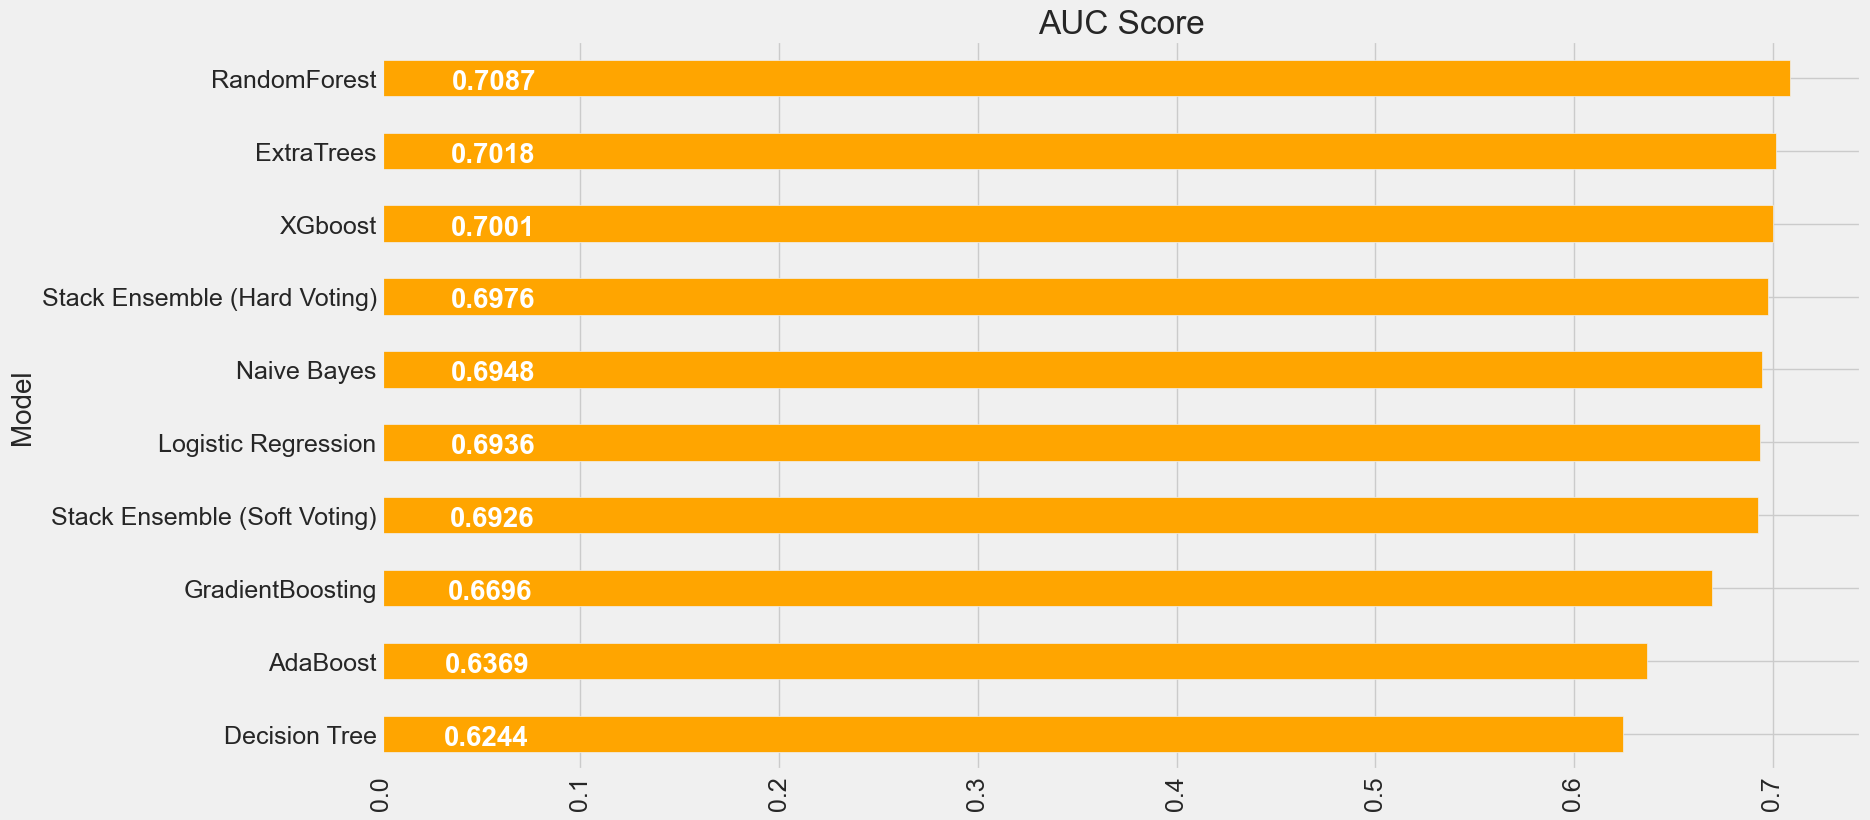

In [56]:
ax = scoreDF['AUC Score'].sort_values().round(6).plot(kind = 'barh', color = 'orange', figsize = (17,9));
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()*0.05, i.get_y()+0.1, \
            str(round((i.get_width()), 4)), fontsize=20,
color='white', fontweight = 'bold')
    
plt.title('AUC Score', fontsize = 24)
plt.xticks(rotation = 90)
plt.show();

In [57]:
final_model = XGBClassifier(n_estimators=100,
                                  random_state=0).fit(X_train, y_train)

In [58]:
# %pip install shap

In [59]:
from sklearn.tree import DecisionTreeClassifier
feature_names = [i for i in df.columns]
tree_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

In [60]:
import shap  # package used to calculate Shap values
row_to_show = 10
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

tree_model.predict_proba(data_for_prediction_array)



# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


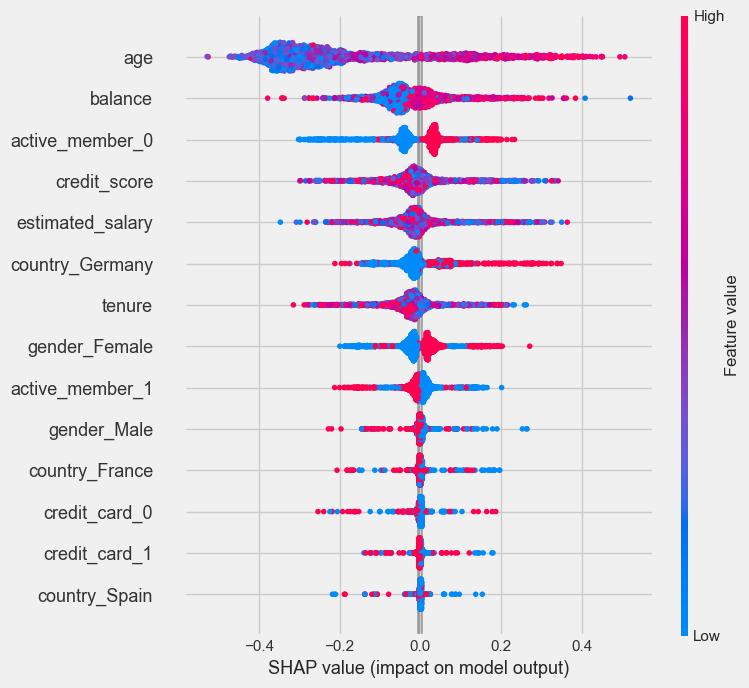

In [61]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1],X_test)

In [62]:
%pip install dowhy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: dowhy in c:\users\legion\appdata\local\programs\python\python39\lib\site-packages (0.10.1)



In [63]:
import dowhy
from dowhy import CausalModel

In [64]:
print(df.columns.tolist())
target_treatment = "active_member"
model = CausalModel(
    data = df,
    treatment= [target_treatment],
    outcome= ["churn"],
    common_causes=df.columns.tolist().remove(target_treatment)
)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True,
                                            method_name="exhaustive-search")
print(identified_estimand)

['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                  
────────────────(E[churn])
d[active_member]          
Estimand assumption 1, Unconfoundedness: If U→{active_member} and U→churn then P(churn|active_member,,U) = P(churn|active_member,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [65]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
cml_estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingClassifier(),
                                                              'model_t': GradientBoostingClassifier(),
                                                              "model_final":GradientBoostingClassifier()},
                                               "fit_params":{}})
print(cml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                  
────────────────(E[churn])
d[active_member]          
Estimand assumption 1, Unconfoundedness: If U→{active_member} and U→churn then P(churn|active_member,,U) = P(churn|active_member,)

## Realized estimand
b: churn~active_member
Target units: ate

## Estimate
Mean value: -0.12581823125963906



In [66]:
res_random = model.refute_estimate(identified_estimand, cml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.12581823125963906
New effect:-0.12581961157861934
p value:0.98



Neural network

In [67]:
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam # I believe this is better optimizer for our case
from tensorflow.keras.preprocessing.image import ImageDataGenerator # to augmenting our images for increasing accuracy
from tensorflow.keras.utils import plot_model


In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [69]:
X_train.shape

In [70]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [71]:
def model_ANN1(input_shape=X_train.shape[1], num_classes=2):   
    model = Sequential()

    model.add(Dense(14, activation='tanh', input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.2))
    # Lets add softmax activated neurons as much as number of classes
    model.add(Dense(1, activation = "sigmoid"))
    # Compile the model with loss and metrics
    model.compile(optimizer =  Adam(learning_rate = 0.00001, decay = 1e-5) , loss = "binary_crossentropy", metrics=["accuracy"])
    
    return model


def model_ANN2(input_shape=X_train.shape[1], num_classes=2):   
    model = Sequential()
    model.add(Dense(14, activation='tanh',  input_dim=X_train.shape[1]))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.4))

    # Lets add softmax activated neurons as much as number of classes
    model.add(Dense(1, activation = "sigmoid"))
    # Compile the model with loss and metrics
    model.compile(optimizer =  Adam(learning_rate = 0.00001, decay = 1e-5) , loss = "binary_crossentropy", metrics=["accuracy"])
    
    return model

In [72]:
ANN_model1 = model_ANN1(input_shape=X_train.shape[1], num_classes=2)
ANN_model2 = model_ANN2(input_shape=X_train.shape[1], num_classes=2)

In [73]:
ANN_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                480       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [74]:
ANN_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 14)                210       
                                                                 
 dropout_5 (Dropout)         (None, 14)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                480       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                

In [75]:
# dot_img_file = 'model_1.png'
# plot_model(ANN_model1, to_file=dot_img_file, show_shapes=True)

In [76]:
# dot_img_file = 'model_2.png'
# plot_model(ANN_model2, to_file=dot_img_file, show_shapes=True)

In [77]:
model = []
model.append(ANN_model1)
model.append(ANN_model2)

In [78]:
models = []
for i in range(len(model)):
    model[i].fit(X_train,y_train, batch_size=32,
                                        epochs = 50,
                                        validation_data = (X_test,y_test), 
                                        callbacks=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)], 
                                        verbose=2)
    models.append(model[i])

Epoch 1/50
396/396 - 2s - loss: 0.7015 - accuracy: 0.4714 - val_loss: 0.7022 - val_accuracy: 0.6105 - lr: 1.0000e-05 - 2s/epoch - 5ms/step
Epoch 2/50
396/396 - 1s - loss: 0.6999 - accuracy: 0.4733 - val_loss: 0.6984 - val_accuracy: 0.6555 - lr: 1.0000e-05 - 535ms/epoch - 1ms/step
Epoch 3/50
396/396 - 1s - loss: 0.6988 - accuracy: 0.4839 - val_loss: 0.6961 - val_accuracy: 0.6950 - lr: 1.0000e-05 - 556ms/epoch - 1ms/step
Epoch 4/50
396/396 - 1s - loss: 0.6970 - accuracy: 0.4861 - val_loss: 0.6943 - val_accuracy: 0.7080 - lr: 1.0000e-05 - 613ms/epoch - 2ms/step
Epoch 5/50
396/396 - 1s - loss: 0.6967 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.7230 - lr: 1.0000e-05 - 542ms/epoch - 1ms/step
Epoch 6/50
396/396 - 1s - loss: 0.6957 - accuracy: 0.4844 - val_loss: 0.6921 - val_accuracy: 0.7450 - lr: 1.0000e-05 - 547ms/epoch - 1ms/step
Epoch 7/50
396/396 - 1s - loss: 0.6955 - accuracy: 0.4938 - val_loss: 0.6917 - val_accuracy: 0.7640 - lr: 1.0000e-05 - 573ms/epoch - 1ms/step
Epoch 8/5

63/63 [==============================] - 0s 968us/step


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


396/396 [==============================] - 0s 969us/step


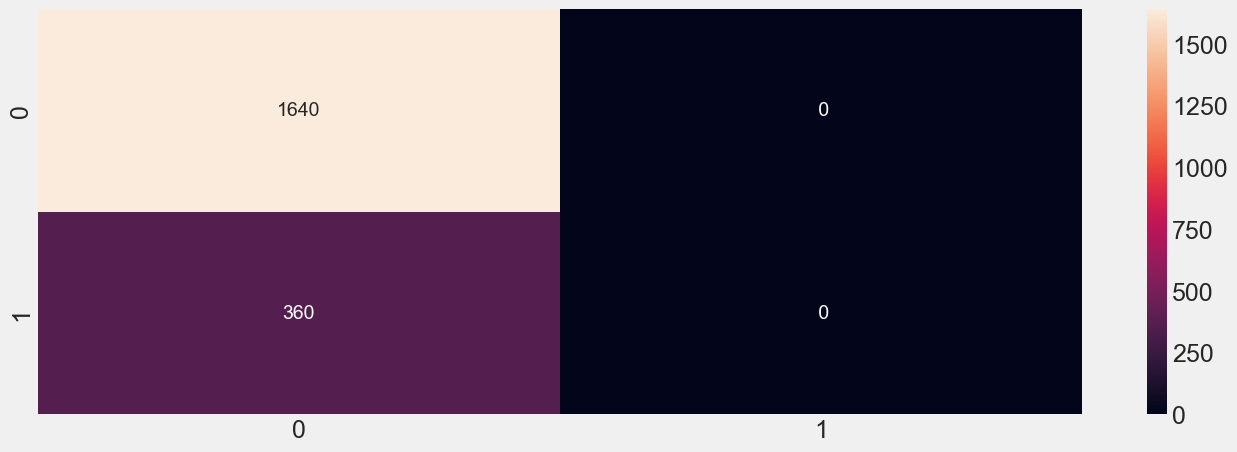

In [79]:
ANN1_preds = (model[0].predict(X_test) > 0.5).astype("int32")
ANN2_preds = (model[1].predict(X_test) > 0.5).astype("int32")
preds = pd.DataFrame({"ANN1" : ANN1_preds.ravel(), "ANN2" : ANN2_preds.ravel()})
ANN_ensemble_predicted = preds.mode(axis=1)
final_preds = ANN_ensemble_predicted.iloc[:, 0].astype("int32")

from sklearn import metrics
CM=metrics.confusion_matrix(y_test,final_preds)
sns.heatmap(CM,annot=True,fmt='2.0f')

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = metrics.log_loss(y_test, final_preds)
acc= accuracy_score(y_test, final_preds)
roc=metrics.roc_auc_score(y_test, final_preds)
prec = metrics.precision_score(y_test, final_preds)
rec = metrics.recall_score(y_test, final_preds)
f1 = metrics.f1_score(y_test, final_preds)

mathew = metrics.matthews_corrcoef(y_test, final_preds)    
ck = cohen_kappa_score(y_test, final_preds)

ANN1_preds = (model[0].predict(X_train) > 0.5).astype("int32")
ANN2_preds = (model[1].predict(X_train) > 0.5).astype("int32")
preds = pd.DataFrame({"ANN1" : ANN1_preds.ravel(), "ANN2" : ANN2_preds.ravel()})
ANN_ensemble_predicted = preds.mode(axis=1)
final_preds = ANN_ensemble_predicted.iloc[:, 0].astype("int32")

train_acc= accuracy_score(y_train, final_preds)